# CNN Model on NSL-KDD

This notebook trains and evaluates a 1D Convolutional Neural Network (CNN) on the preprocessed NSL-KDD dataset.

## 1. Imports and setup

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

sns.set(style="whitegrid")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

## 2. Load preprocessed train / test data

In [14]:
X_train = np.load("../data/processed/X_train.npy").astype("float32")
X_test  = np.load("../data/processed/X_test.npy").astype("float32")
y_train = np.load("../data/processed/y_train.npy").astype("int32").ravel()
y_test  = np.load("../data/processed/y_test.npy").astype("int32").ravel()

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test  shape:", y_test.shape)

n_features = X_train.shape[1]
print("Number of features:", n_features)

X_train shape: (125973, 41)
X_test  shape: (22544, 41)
y_train shape: (125973,)
y_test  shape: (22544,)
Number of features: 41


## 3. Reshape data for 1D CNN

In [15]:
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn  = np.expand_dims(X_test, axis=-1)

print("X_train_cnn shape:", X_train_cnn.shape)
print("X_test_cnn  shape:", X_test_cnn.shape)

X_train_cnn shape: (125973, 41, 1)
X_test_cnn  shape: (22544, 41, 1)


## 4. Build 1D CNN model

In [17]:
input_shape = (n_features, 1)

model_cnn = models.Sequential([
    layers.Input(shape=input_shape),

    # Block 1
    layers.Conv1D(128, kernel_size=3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv1D(128, kernel_size=3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    # Block 2
    layers.Conv1D(256, kernel_size=3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv1D(256, kernel_size=3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.GlobalAveragePooling1D(),

    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(1, activation="sigmoid"),  # binary output: normal vs attack
])

model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
    ],
)

model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 41, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 41, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 20, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 20, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 20, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 447,105 (1.71 MB)

 Trainable params: 445,569 (1.70 MB)

 Non-trainable params: 1,536 (6.00 KB)

## 5. Train the CNN

In [18]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights: make errors on attacks (class 1) more costly
classes = np.array([0, 1])
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train,
)
class_weight_dict = {0: float(class_weights_arr[0]), 1: float(class_weights_arr[1])}
print("Class weights:", class_weight_dict)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1,
)

history_cnn = model_cnn.fit(
    X_train_cnn,
    y_train,
    epochs=80,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1,
)

Class weights: {0: 0.9353087923020953, 1: 1.0743049633293535}
Epoch 1/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 130s 319ms/step - accuracy: 0.9790 - auc: 0.9972 - loss: 0.0585 - val_accuracy: 0.5338 - val_auc: 0.5000 - val_loss: 10.5294 - learning_rate: 0.0010
Epoch 2/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 138s 350ms/step - accuracy: 0.9897 - auc: 0.9990 - loss: 0.0292 - val_accuracy: 0.9832 - val_auc: 0.9991 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 3/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 130s 330ms/step - accuracy: 0.9924 - auc: 0.9993 - loss: 0.0228 - val_accuracy: 0.9917 - val_auc: 0.9996 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 4/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 122s 310ms/step - accuracy: 0.9933 - auc: 0.9995 - loss: 0.0200 - val_accuracy: 0.9870 - val_auc: 0.9994 - val_loss: 0.0281 - learning_rate: 0.0010
Epoch 5/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 117s 298ms/step - accuracy: 0.9935 - auc: 0.9995 - loss: 0.0190 - val_accuracy: 0.9943 - val_auc: 0.9997 - val_loss: 0.0154 - learning_rate: 0.00

## 6. Training curves (accuracy & loss)

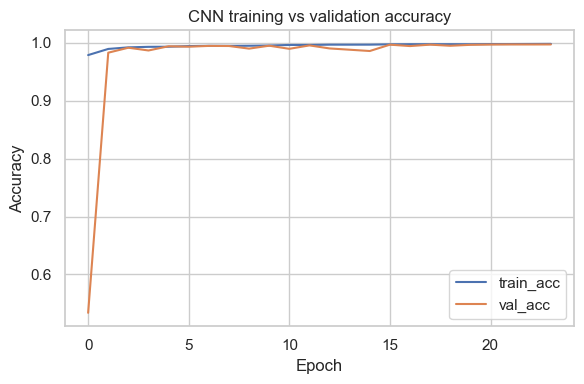

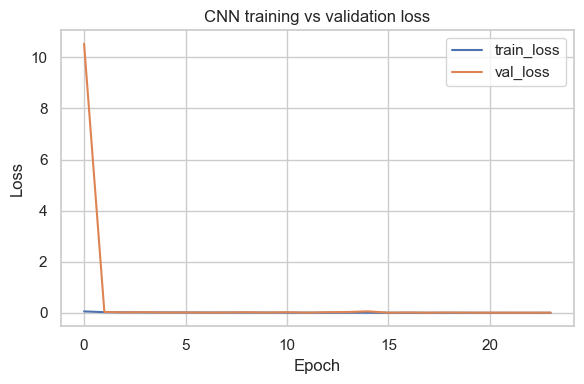

In [19]:
# Accuracy
plt.figure(figsize=(6, 4))
plt.plot(history_cnn.history["accuracy"], label="train_acc")
plt.plot(history_cnn.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN training vs validation accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(6, 4))
plt.plot(history_cnn.history["loss"], label="train_loss")
plt.plot(history_cnn.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN training vs validation loss")
plt.legend()
plt.tight_layout()
plt.show()

## 7. Evaluation on test set

In [20]:
# Base evaluation (for reference)
test_loss_cnn, test_acc_cnn, test_auc_cnn = model_cnn.evaluate(
    X_test_cnn, y_test, verbose=0
)
print(f"Test loss (default) : {test_loss_cnn:.4f}")
print(f"Test acc  (default) : {test_acc_cnn:.4f}")
print(f"Test AUC  (default) : {test_auc_cnn:.4f}")

# Probabilities for class 1 (attack)
y_prob_cnn = model_cnn.predict(X_test_cnn, batch_size=512).ravel()

# Search for best threshold by F1 (attack class = 1)
thresholds = np.linspace(0.1, 0.9, 33)

best_t = 0.5
best_f1 = -1.0
best_prec = 0.0
best_rec = 0.0

for t in thresholds:
    y_pred_t = (y_prob_cnn >= t).astype("int32")
    f1_t = f1_score(y_test, y_pred_t)
    prec_t = precision_score(y_test, y_pred_t)
    rec_t = recall_score(y_test, y_pred_t)
    if f1_t > best_f1:
        best_f1 = f1_t
        best_t = t
        best_prec = prec_t
        best_rec = rec_t

print("\n=== Best threshold search (by F1) ===")
print(f"Best threshold: {best_t:.3f}")
print(f"Precision@best_t: {best_prec:.4f}")
print(f"Recall@best_t   : {best_rec:.4f}")
print(f"F1@best_t       : {best_f1:.4f}")

# Final predictions using best threshold
y_pred_cnn = (y_prob_cnn >= best_t).astype("int32")

acc_cnn  = accuracy_score(y_test, y_pred_cnn)
prec_cnn = precision_score(y_test, y_pred_cnn)
rec_cnn  = recall_score(y_test, y_pred_cnn)
f1_cnn   = f1_score(y_test, y_pred_cnn)
auc_cnn  = roc_auc_score(y_test, y_prob_cnn)

print("\n=== CNN metrics on test set (tuned threshold) ===")
print(f"Threshold: {best_t:.3f}")
print(f"Accuracy : {acc_cnn:.4f}")
print(f"Precision: {prec_cnn:.4f}")
print(f"Recall   : {rec_cnn:.4f}")
print(f"F1-score : {f1_cnn:.4f}")
print(f"ROC-AUC  : {auc_cnn:.4f}")

print("\nClassification report (0 = normal, 1 = attack):\n")
print(classification_report(y_test, y_pred_cnn, target_names=["normal", "attack"]))

Test loss (default) : 2.3600
Test acc  (default) : 0.7839
Test AUC  (default) : 0.8537
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step

=== Best threshold search (by F1) ===
Best threshold: 0.100
Precision@best_t: 0.9616
Recall@best_t   : 0.6800
F1@best_t       : 0.7966

=== CNN metrics on test set (tuned threshold) ===
Threshold: 0.100
Accuracy : 0.8024
Precision: 0.9616
Recall   : 0.6800
F1-score : 0.7966
ROC-AUC  : 0.9478

Classification report (0 = normal, 1 = attack):

              precision    recall  f1-score   support

      normal       0.70      0.96      0.81      9711
      attack       0.96      0.68      0.80     12833

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.80     22544



## 8. Confusion matrix & ROC curve

Confusion matrix (CNN, tuned threshold):
[[9363  348]
 [4107 8726]]


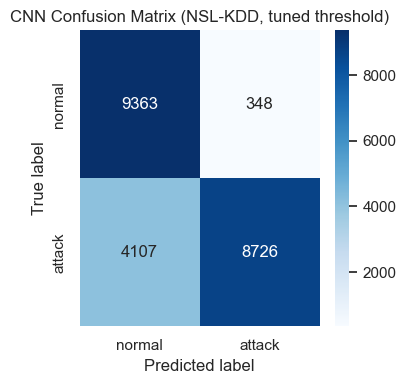

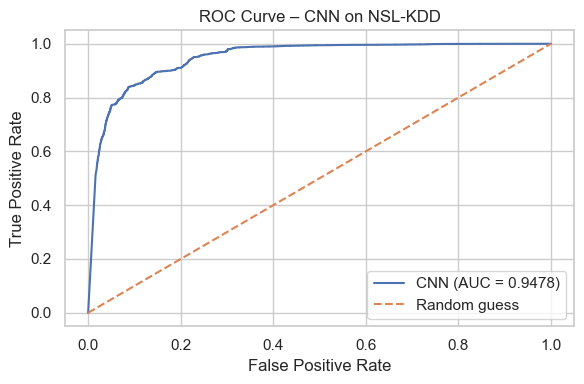

In [23]:
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
print("Confusion matrix (CNN, tuned threshold):")
print(cm_cnn)

plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_cnn,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["normal", "attack"],
    yticklabels=["normal", "attack"],
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CNN Confusion Matrix (NSL-KDD, tuned threshold)")
plt.tight_layout()
plt.show()

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_prob_cnn)
roc_auc_plot_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure(figsize=(6, 4))
plt.plot(fpr_cnn, tpr_cnn, label=f"CNN (AUC = {roc_auc_plot_cnn:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – CNN on NSL-KDD")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 9. Summary table

In [24]:
metrics_cnn = pd.DataFrame(
    {
        "model": ["CNN"],
        "accuracy": [acc_cnn],
        "precision": [prec_cnn],
        "recall": [rec_cnn],
        "f1": [f1_cnn],
        "roc_auc": [auc_cnn],
    }
)

metrics_cnn

import os

os.makedirs("../results", exist_ok=True)
cnn_metrics_path = "../results/cnn_metrics.csv"
metrics_cnn.to_csv(cnn_metrics_path, index=False)
print(f"Saved CNN metrics to {cnn_metrics_path}")

Saved CNN metrics to ../results/cnn_metrics.csv
